## The data are measured daily in one location by lab 

In [107]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from pandas import concat

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from numpy import concatenate

from sklearn.metrics import mean_squared_error
from math import sqrt

from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras import Input, Model
from keras.layers import Dense
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

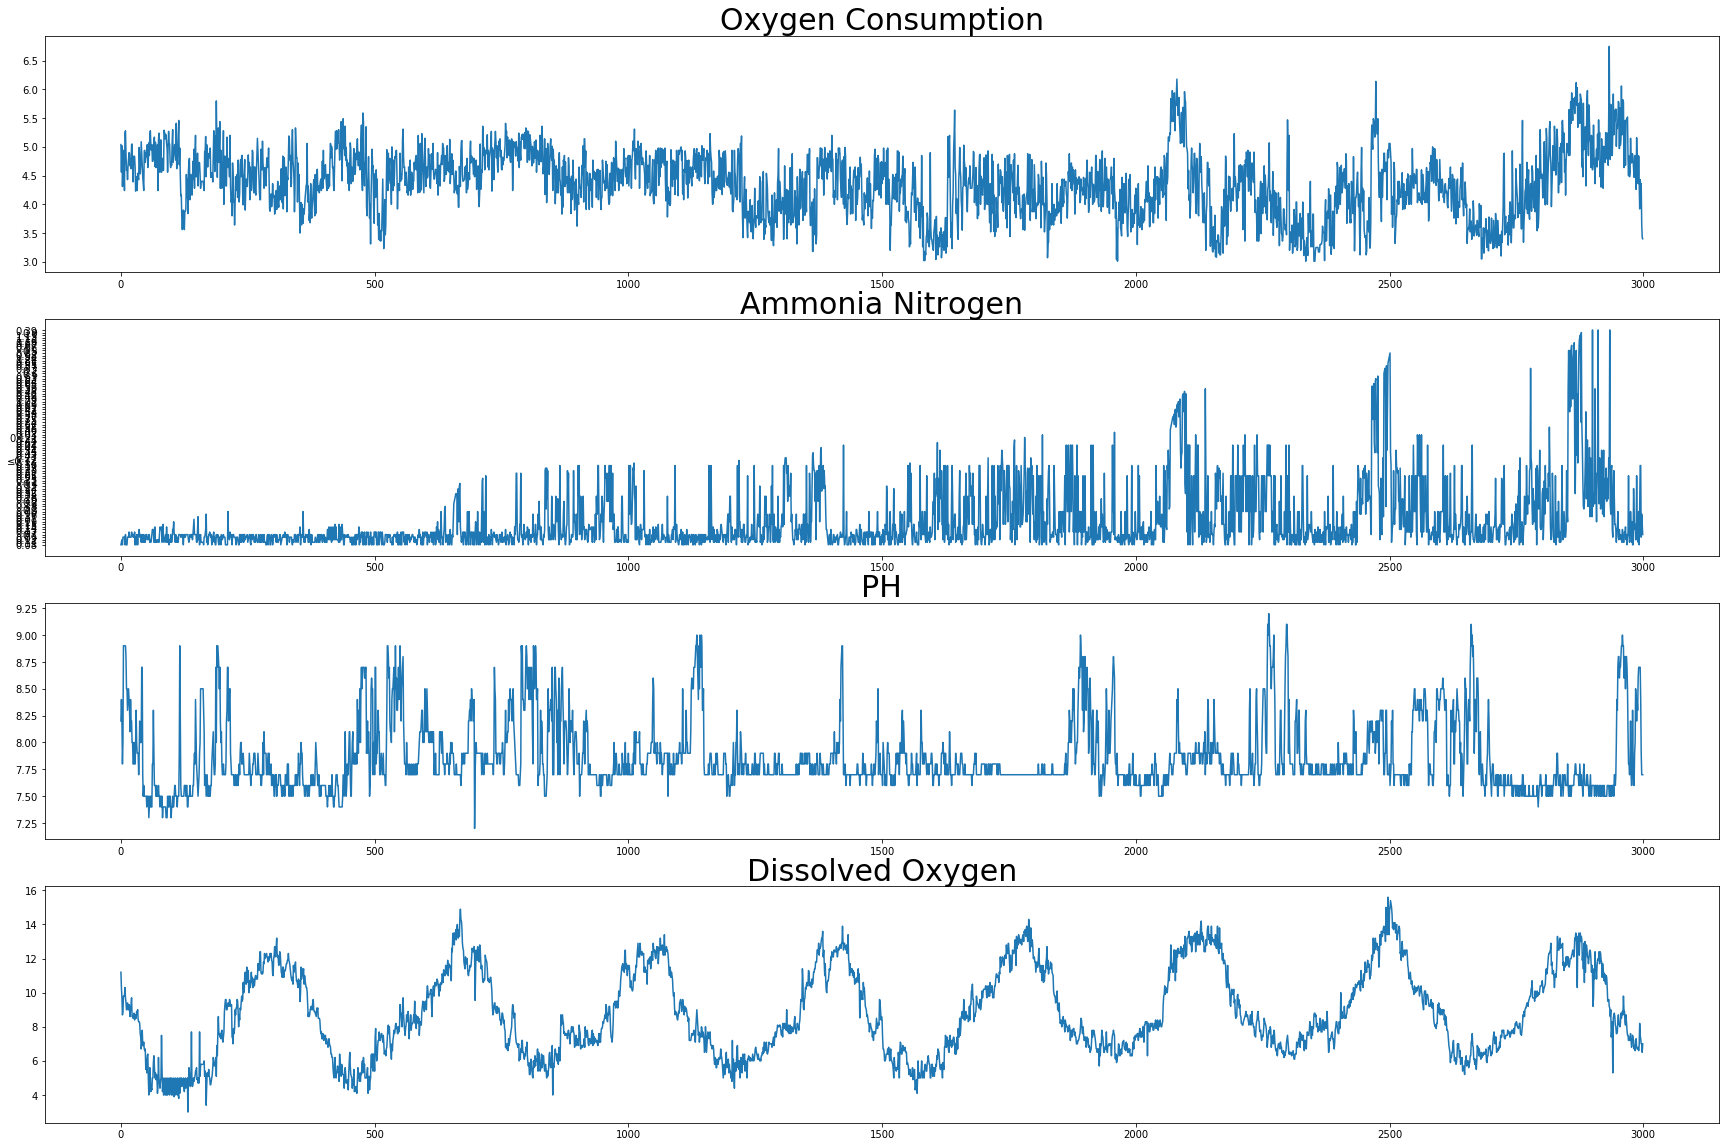

In [108]:
#载入数据
dataset = pd.read_csv('Water Quality Record.csv', header=0, index_col=0, parse_dates=True)
values = dataset.values
groups = [ 0, 1, 2, 3]
fig, axs = plt.subplots(1)
i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], fontsize=30)
    i+=1
plt.show()


In [109]:
df=pd.DataFrame(dataset)
do=df['Dissolved Oxygen']
oc=df['Oxygen Consumption']
an=df['Ammonia Nitrogen']

# Data preprocessing

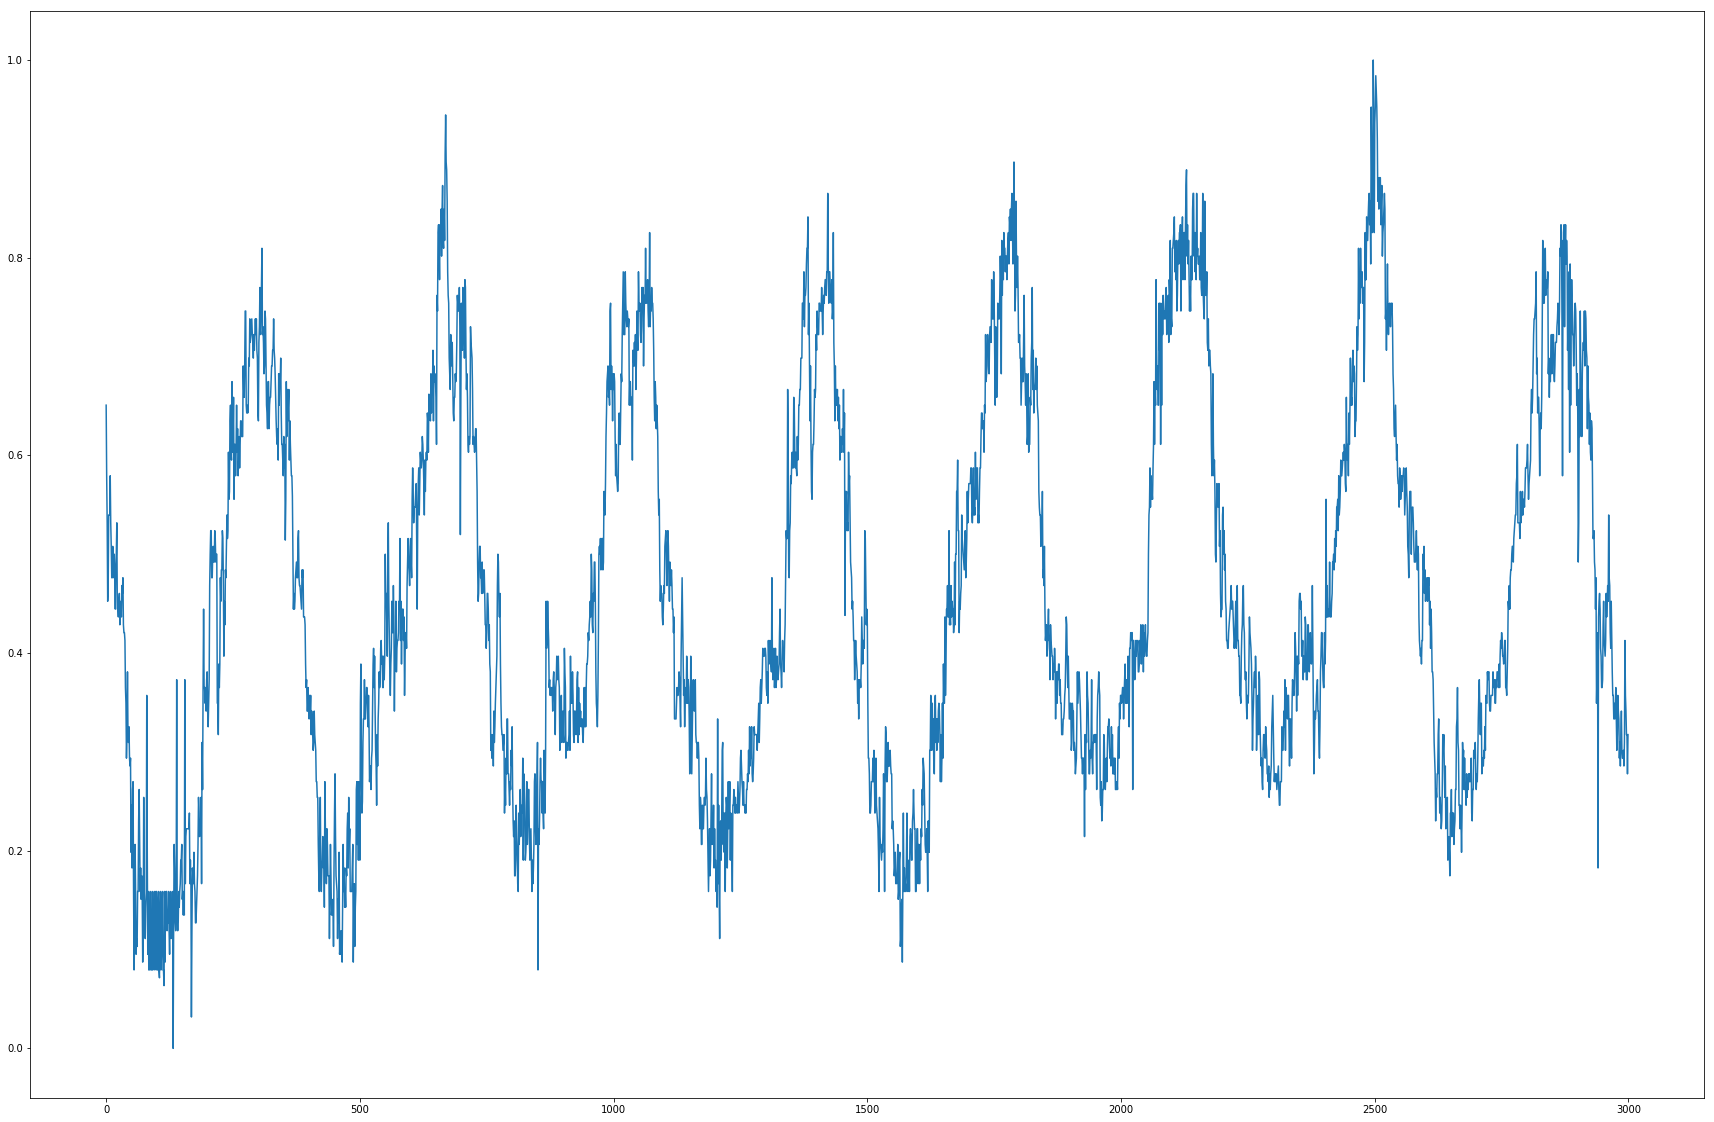

In [110]:
DO=[]
for i in range(0,len(do)):  
    DO.append([do[i]])
scaler_DO = MinMaxScaler(feature_range=(0,1))  
DO = scaler_DO.fit_transform(DO)
plt.plot(DO)
#I tried both MinMax scaler and Standard scaler
#(which is Z score standardization), and MinMaxScaler has obrious better result

In [112]:
from tcn import TCN

In [113]:
def data_split_TCN(data, train_len, lookback_window):
    train=data[:train_len]
    test=data[train_len:]
    X1, y1=[], []
    for i in range(lookback_window, len(train)):
        X1.append(train[i - lookback_window:i])
        y1.append(train[i])
        y_train = np.array(y1)
        X_train = np.array(X1)

    X2, y2=[], []
    for i in range(lookback_window, len(test)):
        X2.append(test[i - lookback_window:i])
        y2.append(test[i])
        y_test = np.array(y2)
        X_test = np.array(X2)
    
    return (X_train, y_train, X_test, y_test)

In [114]:
def data_split_LSTM(X_train,y_train, X_test, y_test, lookback_windows): #data split for LSTM is also fit to GRU
    # reshape the data to satisfy the input acquirement of LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
    
    return (X_train, y_train, X_test, y_test)

In [115]:
#Visualization
def visualize(history):
    plt.rcParams['figure.figsize'] = (10.0, 6.0)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [139]:
def TCN_Model(X_train, y_train, lookback_window):
    i = Input(shape=(lookback_window, 1))
    m = TCN()(i)
    m = Dense(1, activation='linear')(m)
    model = Model(inputs=[i], outputs=[m])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=5, validation_split=0.1, shuffle=True, verbose=1)
    return (model)

In [140]:
def LSTM_Model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=5,  batch_size=1,  validation_split=0.1, verbose=1, shuffle=True) 
    return(model)
#batch_size=1 has the best result, although its disadvantage is it needs much longer time

In [141]:
def GRU_Model(X_train, y_train):
    model = Sequential()
    model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=5,  batch_size=1,  validation_split=0.1, verbose=1, shuffle=True)
    return(model)

In [142]:
c=int(len(df)*.9)

# DO

In [154]:
X1_train, y1_train, X1_test, y1_test =data_split_TCN(DO, c, 1) #TCN
X2_train, y2_train, X2_test, y2_test = data_split_LSTM(X1_train, y1_train, X1_test, y1_test, 1)  #LSTM
X3_train, y3_train, X3_test, y3_test = data_split_LSTM(X1_train, y1_train, X1_test, y1_test, 1)  #GRU

In [155]:
model_DO_TCN=TCN_Model(X1_train, y1_train, 1)

Train on 2429 samples, validate on 270 samples
Epoch 1/5
2429/2429 [==============================] - 14s 6ms/step - loss: 0.0850 - val_loss: 0.0014
Epoch 2/5
2429/2429 [==============================] - 3s 1ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 3/5
2429/2429 [==============================] - 3s 1ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4/5
2429/2429 [==============================] - 3s 1ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 5/5
2429/2429 [==============================] - 3s 1ms/step - loss: 0.0025 - val_loss: 0.0014


In [156]:
model_DO_LSTM=LSTM_Model(X2_train, y2_train)

Train on 2429 samples, validate on 270 samples
Epoch 1/5
2429/2429 [==============================] - 25s 10ms/step - loss: 0.0091 - val_loss: 0.0014
Epoch 2/5
2429/2429 [==============================] - 15s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/5
2429/2429 [==============================] - 15s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/5
2429/2429 [==============================] - 14s 6ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/5
2429/2429 [==============================] - 15s 6ms/step - loss: 0.0018 - val_loss: 0.0016


In [157]:
model_DO_GRU=GRU_Model(X3_train, y3_train)

Train on 2429 samples, validate on 270 samples
Epoch 1/5
2429/2429 [==============================] - 25s 10ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 2/5
2429/2429 [==============================] - 18s 7ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/5
2429/2429 [==============================] - 17s 7ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/5
2429/2429 [==============================] - 21s 8ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/5
2429/2429 [==============================] - 18s 7ms/step - loss: 0.0019 - val_loss: 0.0015


In [147]:
#TCN original data 
y1_train_hat=model_DO_TCN.predict(X1_train)
y1_train_hat=scaler_DO.inverse_transform(y1_train_hat)
y1_train=scaler_DO.inverse_transform(y1_train)

y1_test_hat=model_DO_TCN.predict(X1_test)
y1_test_hat=scaler_DO.inverse_transform(y1_test_hat)
y1_test=scaler_DO.inverse_transform(y1_test)


In [148]:
def plot_curve(true_data, predicted):
 
    plt.plot(true_data, label='True data')
    plt.plot(predicted, label='Predicted data')
    #plt.plot(predicted_LSTM, label='Predicted data by LSTM')
    plt.legend()
    plt.savefig('result.png')
    plt.show()


### TCN

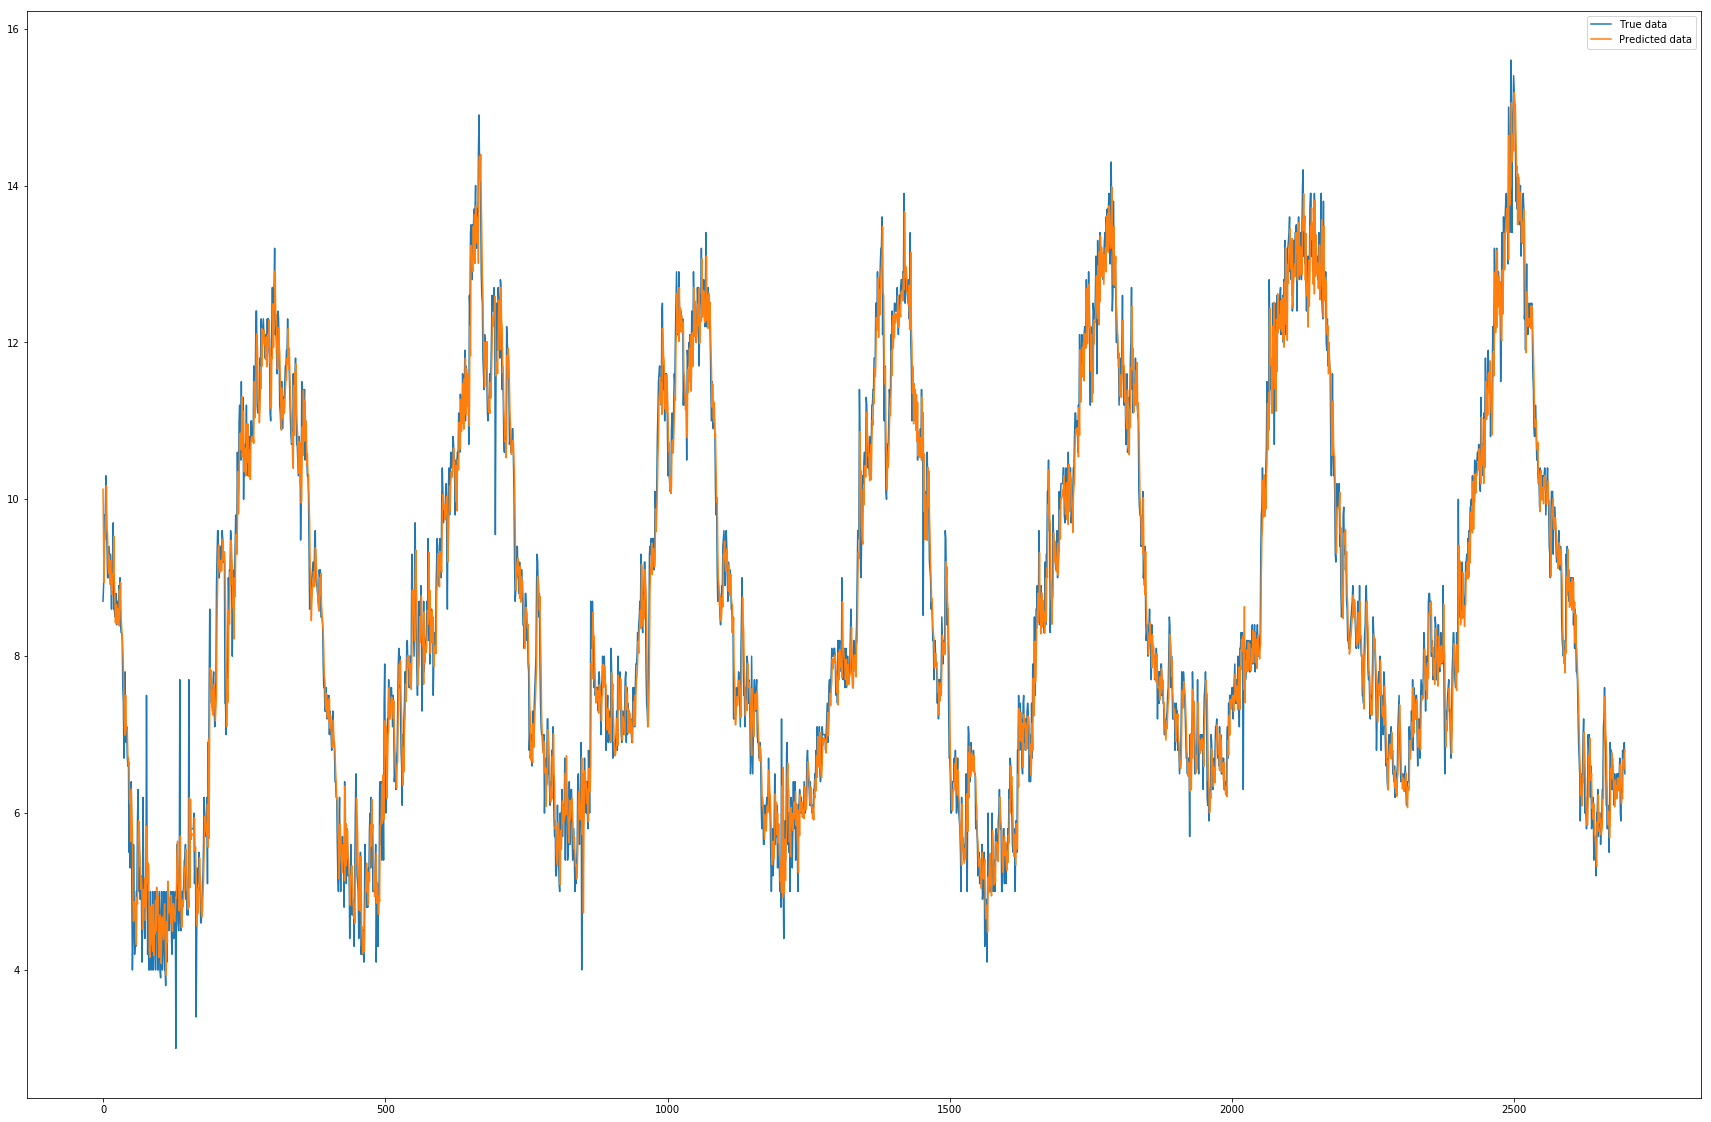

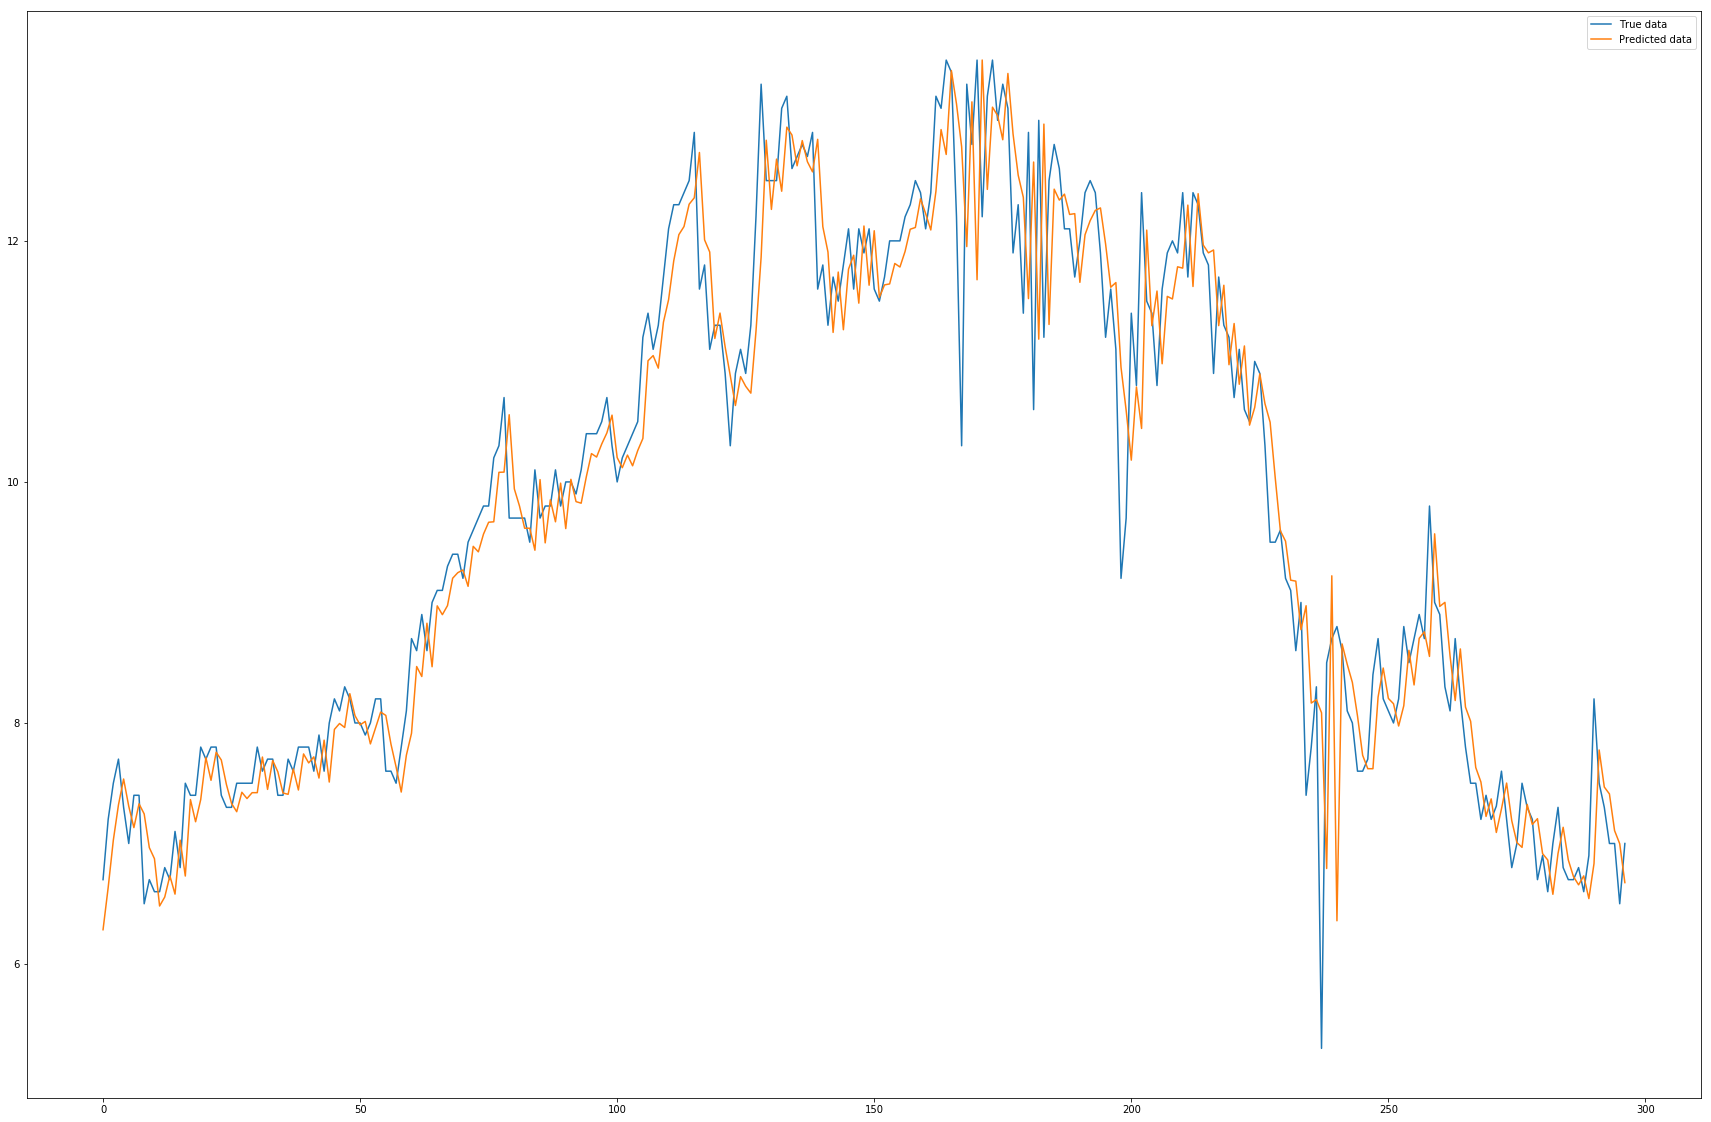

In [149]:
plot_curve(y1_train, y1_train_hat)
plot_curve(y1_test, y1_test_hat)

#### LSTM

In [150]:
y2_train_hat=model_DO_LSTM.predict(X2_train)
y2_train_hat=scaler_DO.inverse_transform(y2_train_hat)
y2_train=scaler_DO.inverse_transform(y2_train)

y2_test_hat=model_DO_LSTM.predict(X2_test)
y2_test_hat=scaler_DO.inverse_transform(y2_test_hat)
y2_test=scaler_DO.inverse_transform(y2_test)

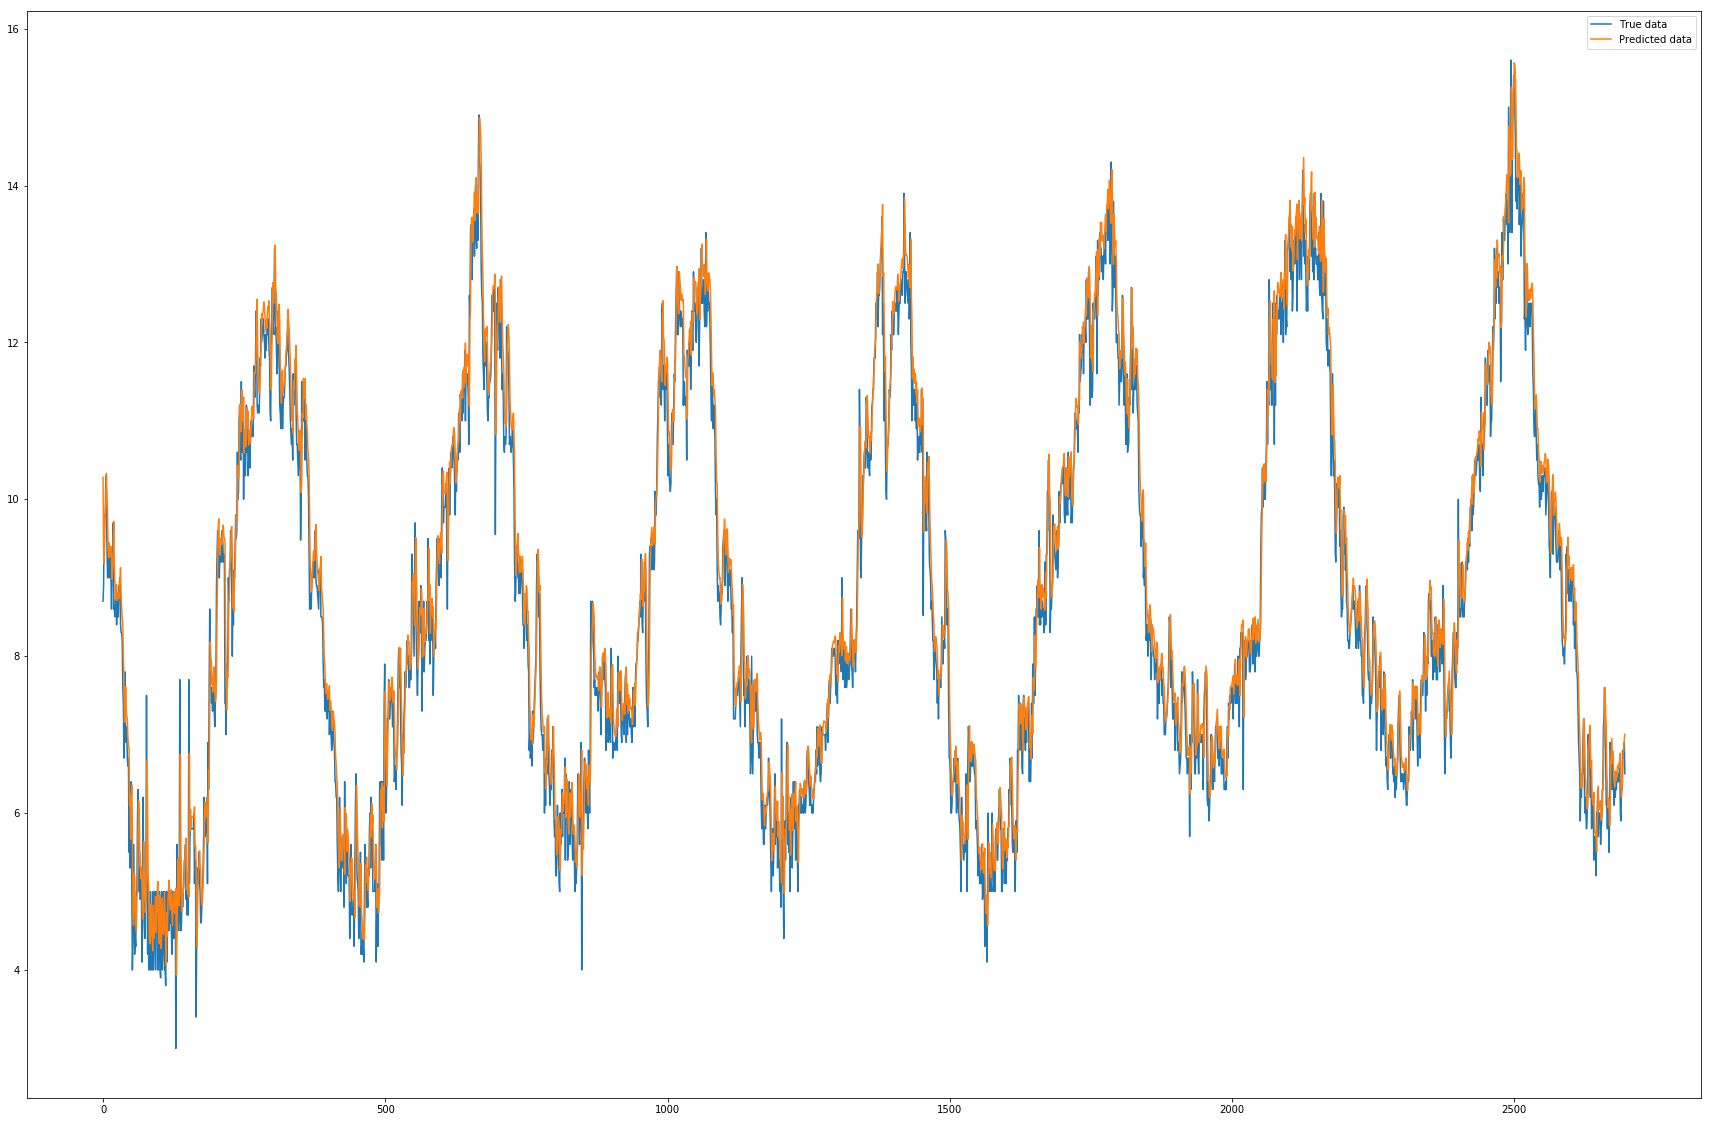

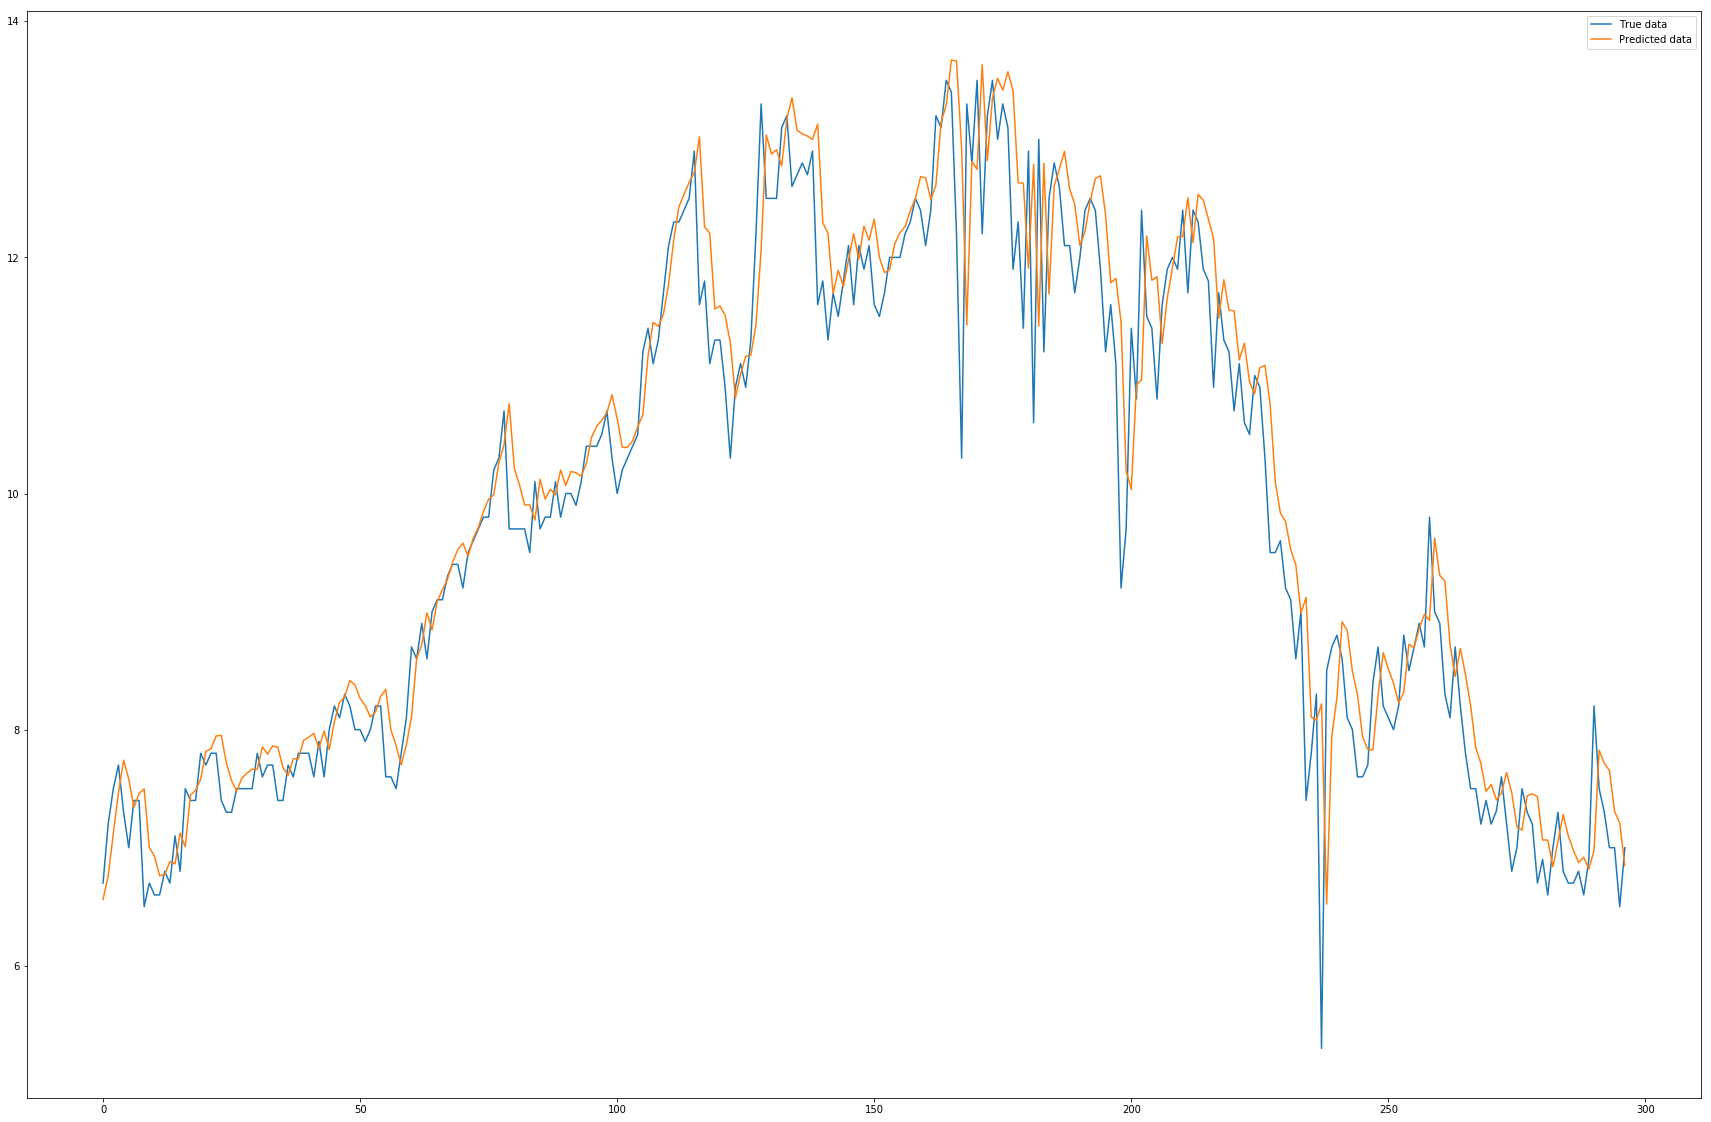

In [151]:
plot_curve(y2_train, y2_train_hat)
plot_curve(y2_test, y2_test_hat)

### GRU

In [152]:
y3_train_hat=model_DO_GRU.predict(X3_train)
y3_train_hat=scaler_DO.inverse_transform(y3_train_hat)
y3_train=scaler_DO.inverse_transform(y3_train)

y3_test_hat=model_DO_GRU.predict(X3_test)
y3_test_hat=scaler_DO.inverse_transform(y3_test_hat)
y3_test=scaler_DO.inverse_transform(y3_test)

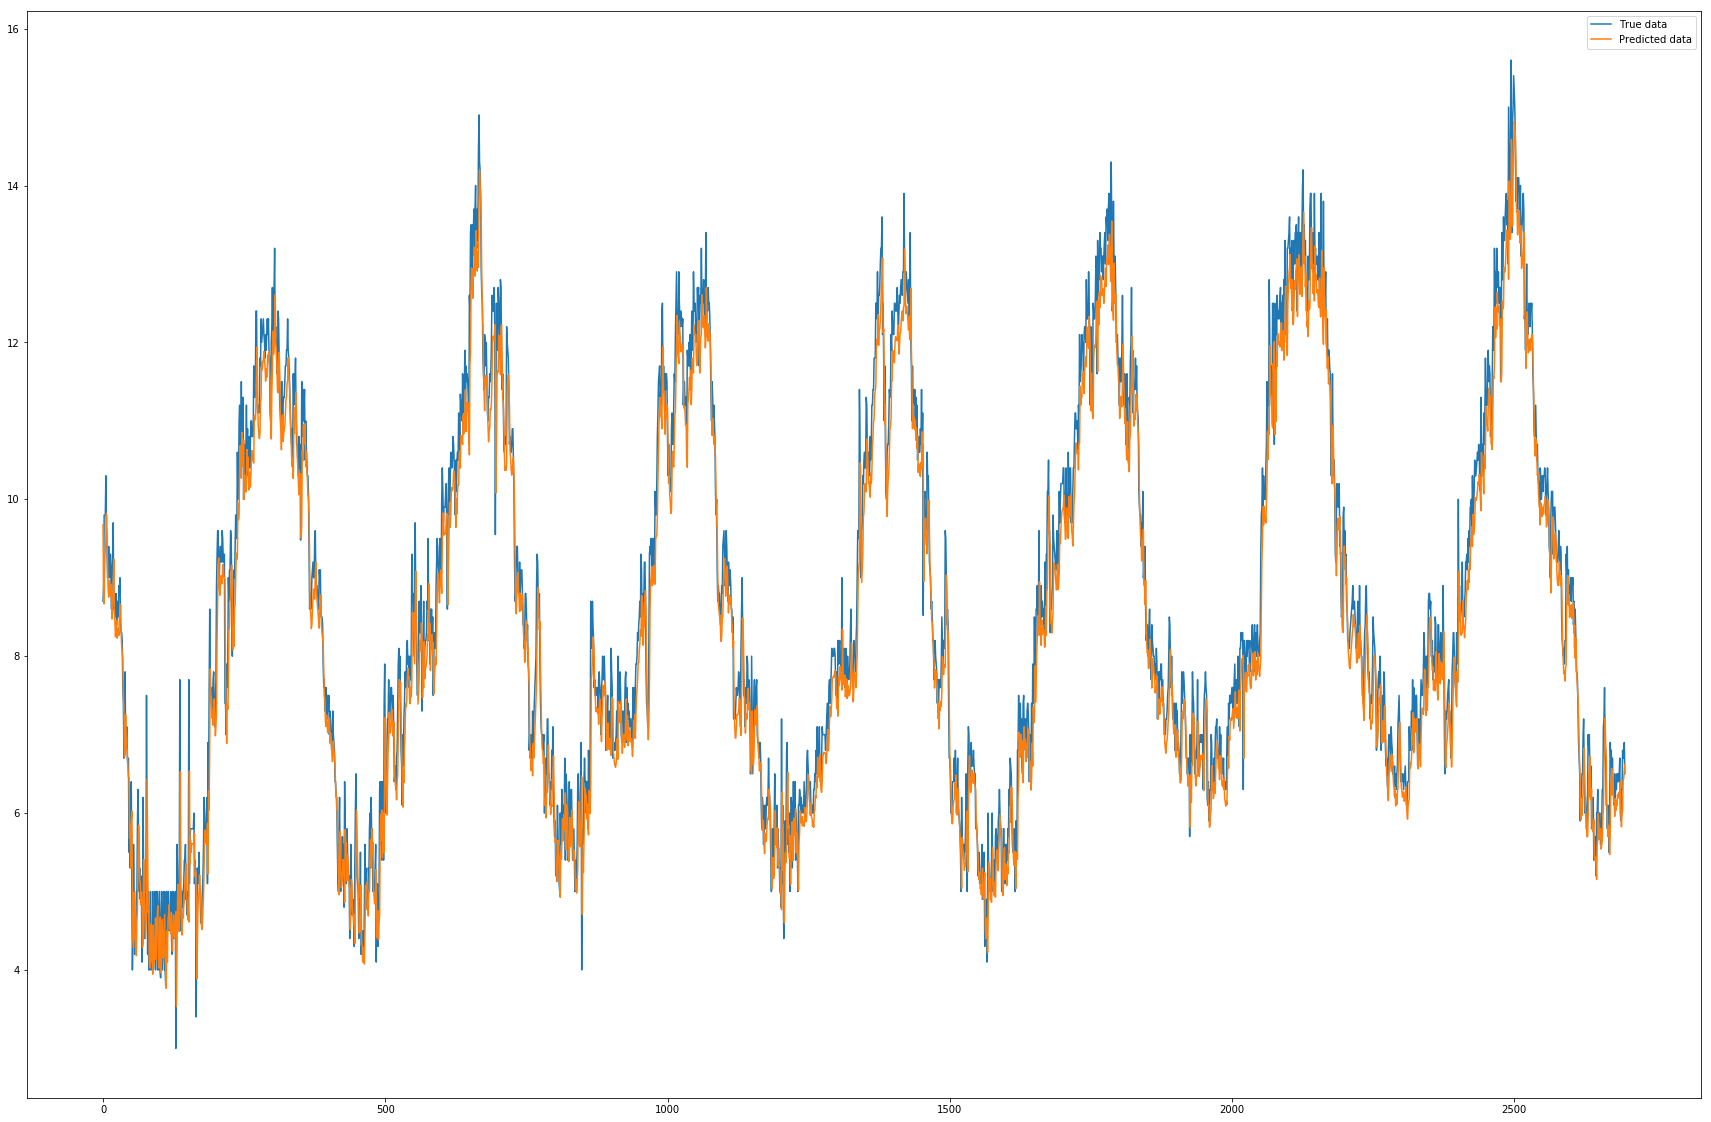

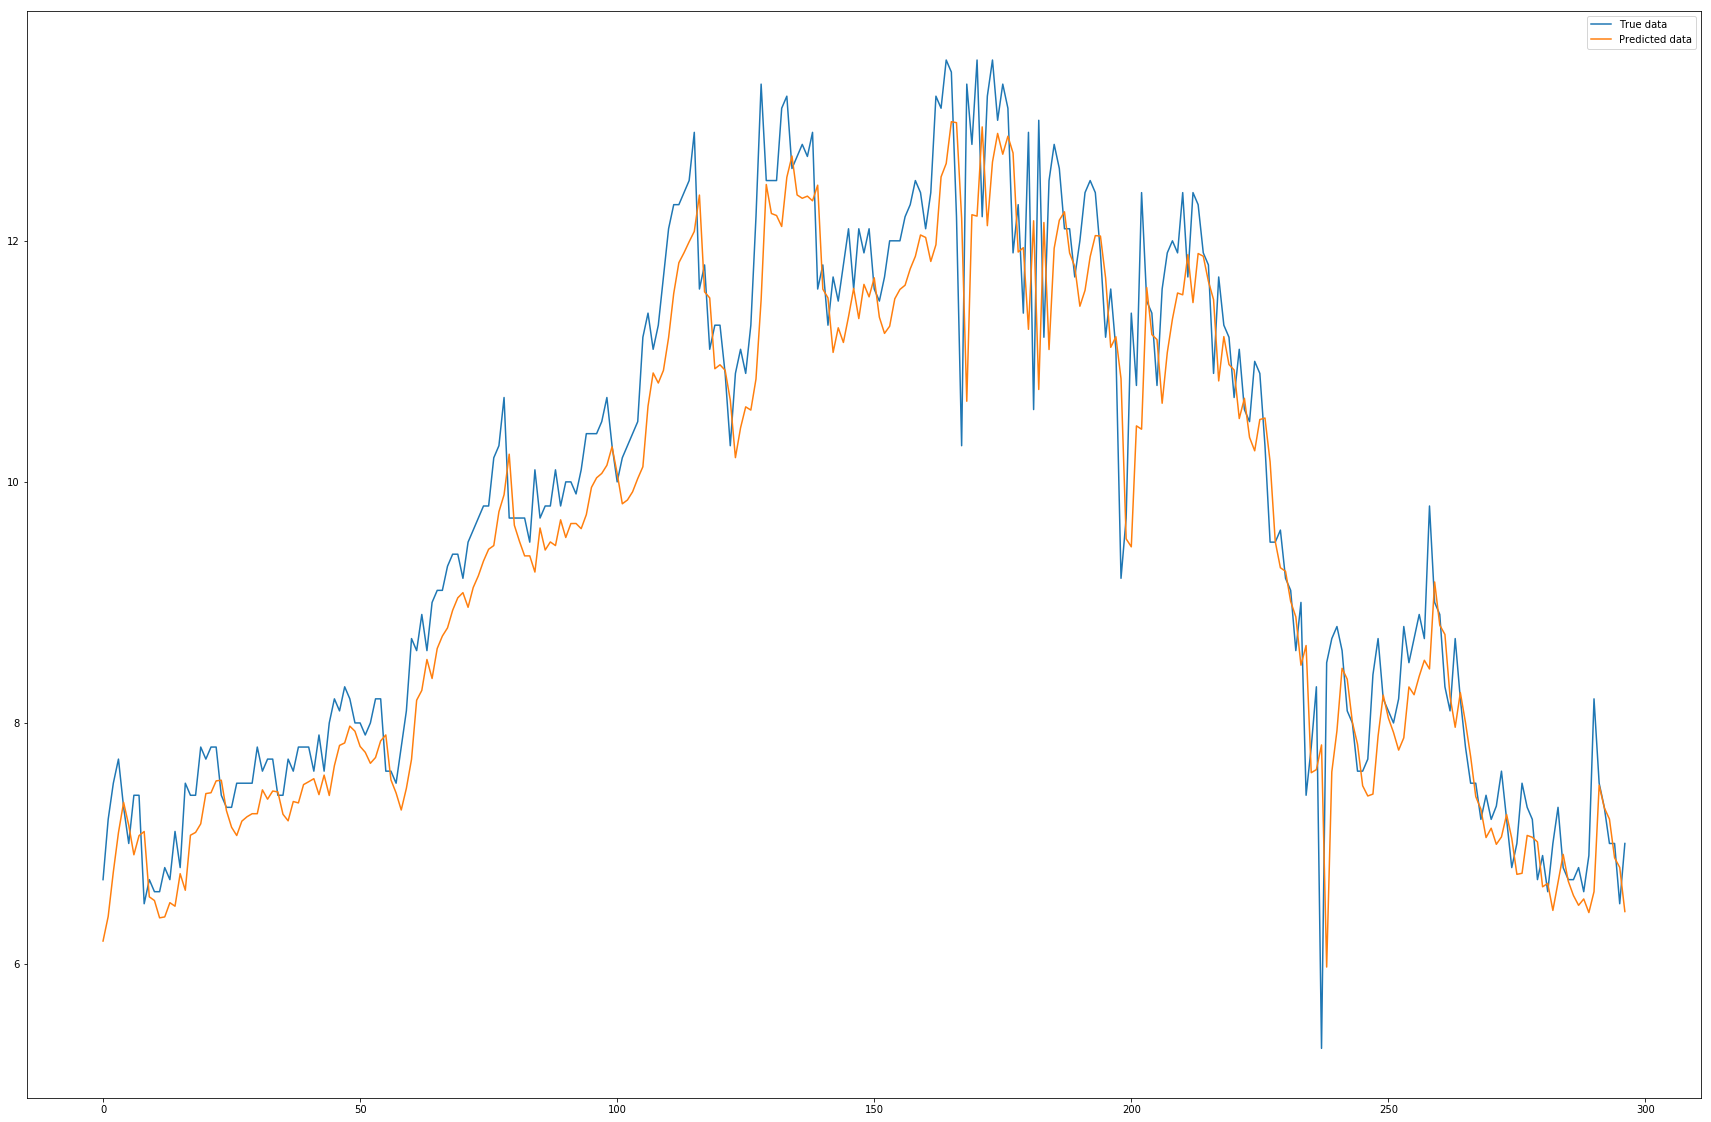

In [153]:
plot_curve(y3_train, y3_train_hat)
plot_curve(y3_test, y3_test_hat)